In [118]:
import os
import pandas as pd
import numpy as np
import functools
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import RocCurveDisplay, roc_auc_score, f1_score, classification_report

In [119]:
import warnings
warnings.simplefilter("ignore", UserWarning)

In [120]:
data = {dataset_name.replace('.xlsx', ''): pd.read_excel(f'Data/{dataset_name}') for dataset_name in os.listdir('Data') if 'xlsx' in dataset_name} 

print(list(data.keys()))

['test_demo', 'test_habits', 'test_health', 'train_demo', 'train_habits', 'train_health']


In [121]:
data_frames = [data['train_demo'], data['train_habits'], data['train_health']]
df = functools.reduce(lambda  left,right: pd.merge(left,right,on=['PatientID'], how='outer'), data_frames).set_index('PatientID')

data_frames = [data['test_demo'], data['test_habits'], data['test_health']]
df_test = functools.reduce(lambda  left,right: pd.merge(left,right,on=['PatientID'], how='outer'), data_frames).set_index('PatientID')

---
# Baseline

- only numeric features

In [122]:
x, y = df.drop(columns = ['Disease']), df['Disease']

xnumeric = x.select_dtypes(include = np.number)

xtrain, xval, ytrain, yval = train_test_split(xnumeric, y, random_state = 111 ,test_size = 0.3, shuffle = True , stratify = y)

xtrain_index = xtrain.index
xval_index = xval.index

model = LogisticRegression(max_iter = 500, random_state = 1)
model.fit(xtrain,ytrain)

ypred = model.predict(xval)

f1_score(yval, ypred)

0.7547169811320754

---
# Preprocessing

In [123]:
def cleaning(dataframe):

    # fix Birth_Year errors (1869 > 1969)
    dataframe['Birth_Year'] = [i + 100 if i < 1900 else i for i in dataframe['Birth_Year']]

    # add Age column
    dataframe['Age'] = [2022 - i for i in dataframe['Birth_Year']]

    # add Gender column (1: Male, 0: Female)
    # afterwards drop column Name
    dataframe['Gender']  = [1 if i.split(' ')[0] == 'Mr.' else 0 for i in dataframe['Name']]
    dataframe.drop(columns = ['Name'], inplace = True)

    # add column population density
    dataframe['Region'] = [i.lower() for i in dataframe['Region']]
    dataframe['Region_Density'] = [dataframe['Region'].value_counts(normalize = True)[i] for i in dataframe['Region']]

    # encode Smoking_Habit & Exercise to binary (1: Yes, 0: No)
    dataframe['Smoking_Habit'] = [1 if i == 'Yes' else 0 for i in dataframe['Smoking_Habit']]
    dataframe['Exercise'] = [1 if i == 'Yes' else 0 for i in dataframe['Exercise']]

    # impute missing values in column "Education" with mode
    dataframe['Education'].fillna(dataframe['Education'].mode()[0], inplace=True)

    # remove outliers with IQR method
    q1, q3, iqr = xnumeric.quantile(0.25), xnumeric.quantile(0.75), xnumeric.quantile(0.75) - xnumeric.quantile(0.25)
    idx_outliers = []
    return dataframe

In [127]:
df.Birth_Year[~]

PatientID
1167    1965
1805    1969
1557    1974
1658    1958
1544    1968
        ... 
1909    1972
1386    1980
1088    1960
1662    1975
1117    1979
Name: Birth_Year, Length: 800, dtype: int64

In [124]:
cleandf = cleaning(df)

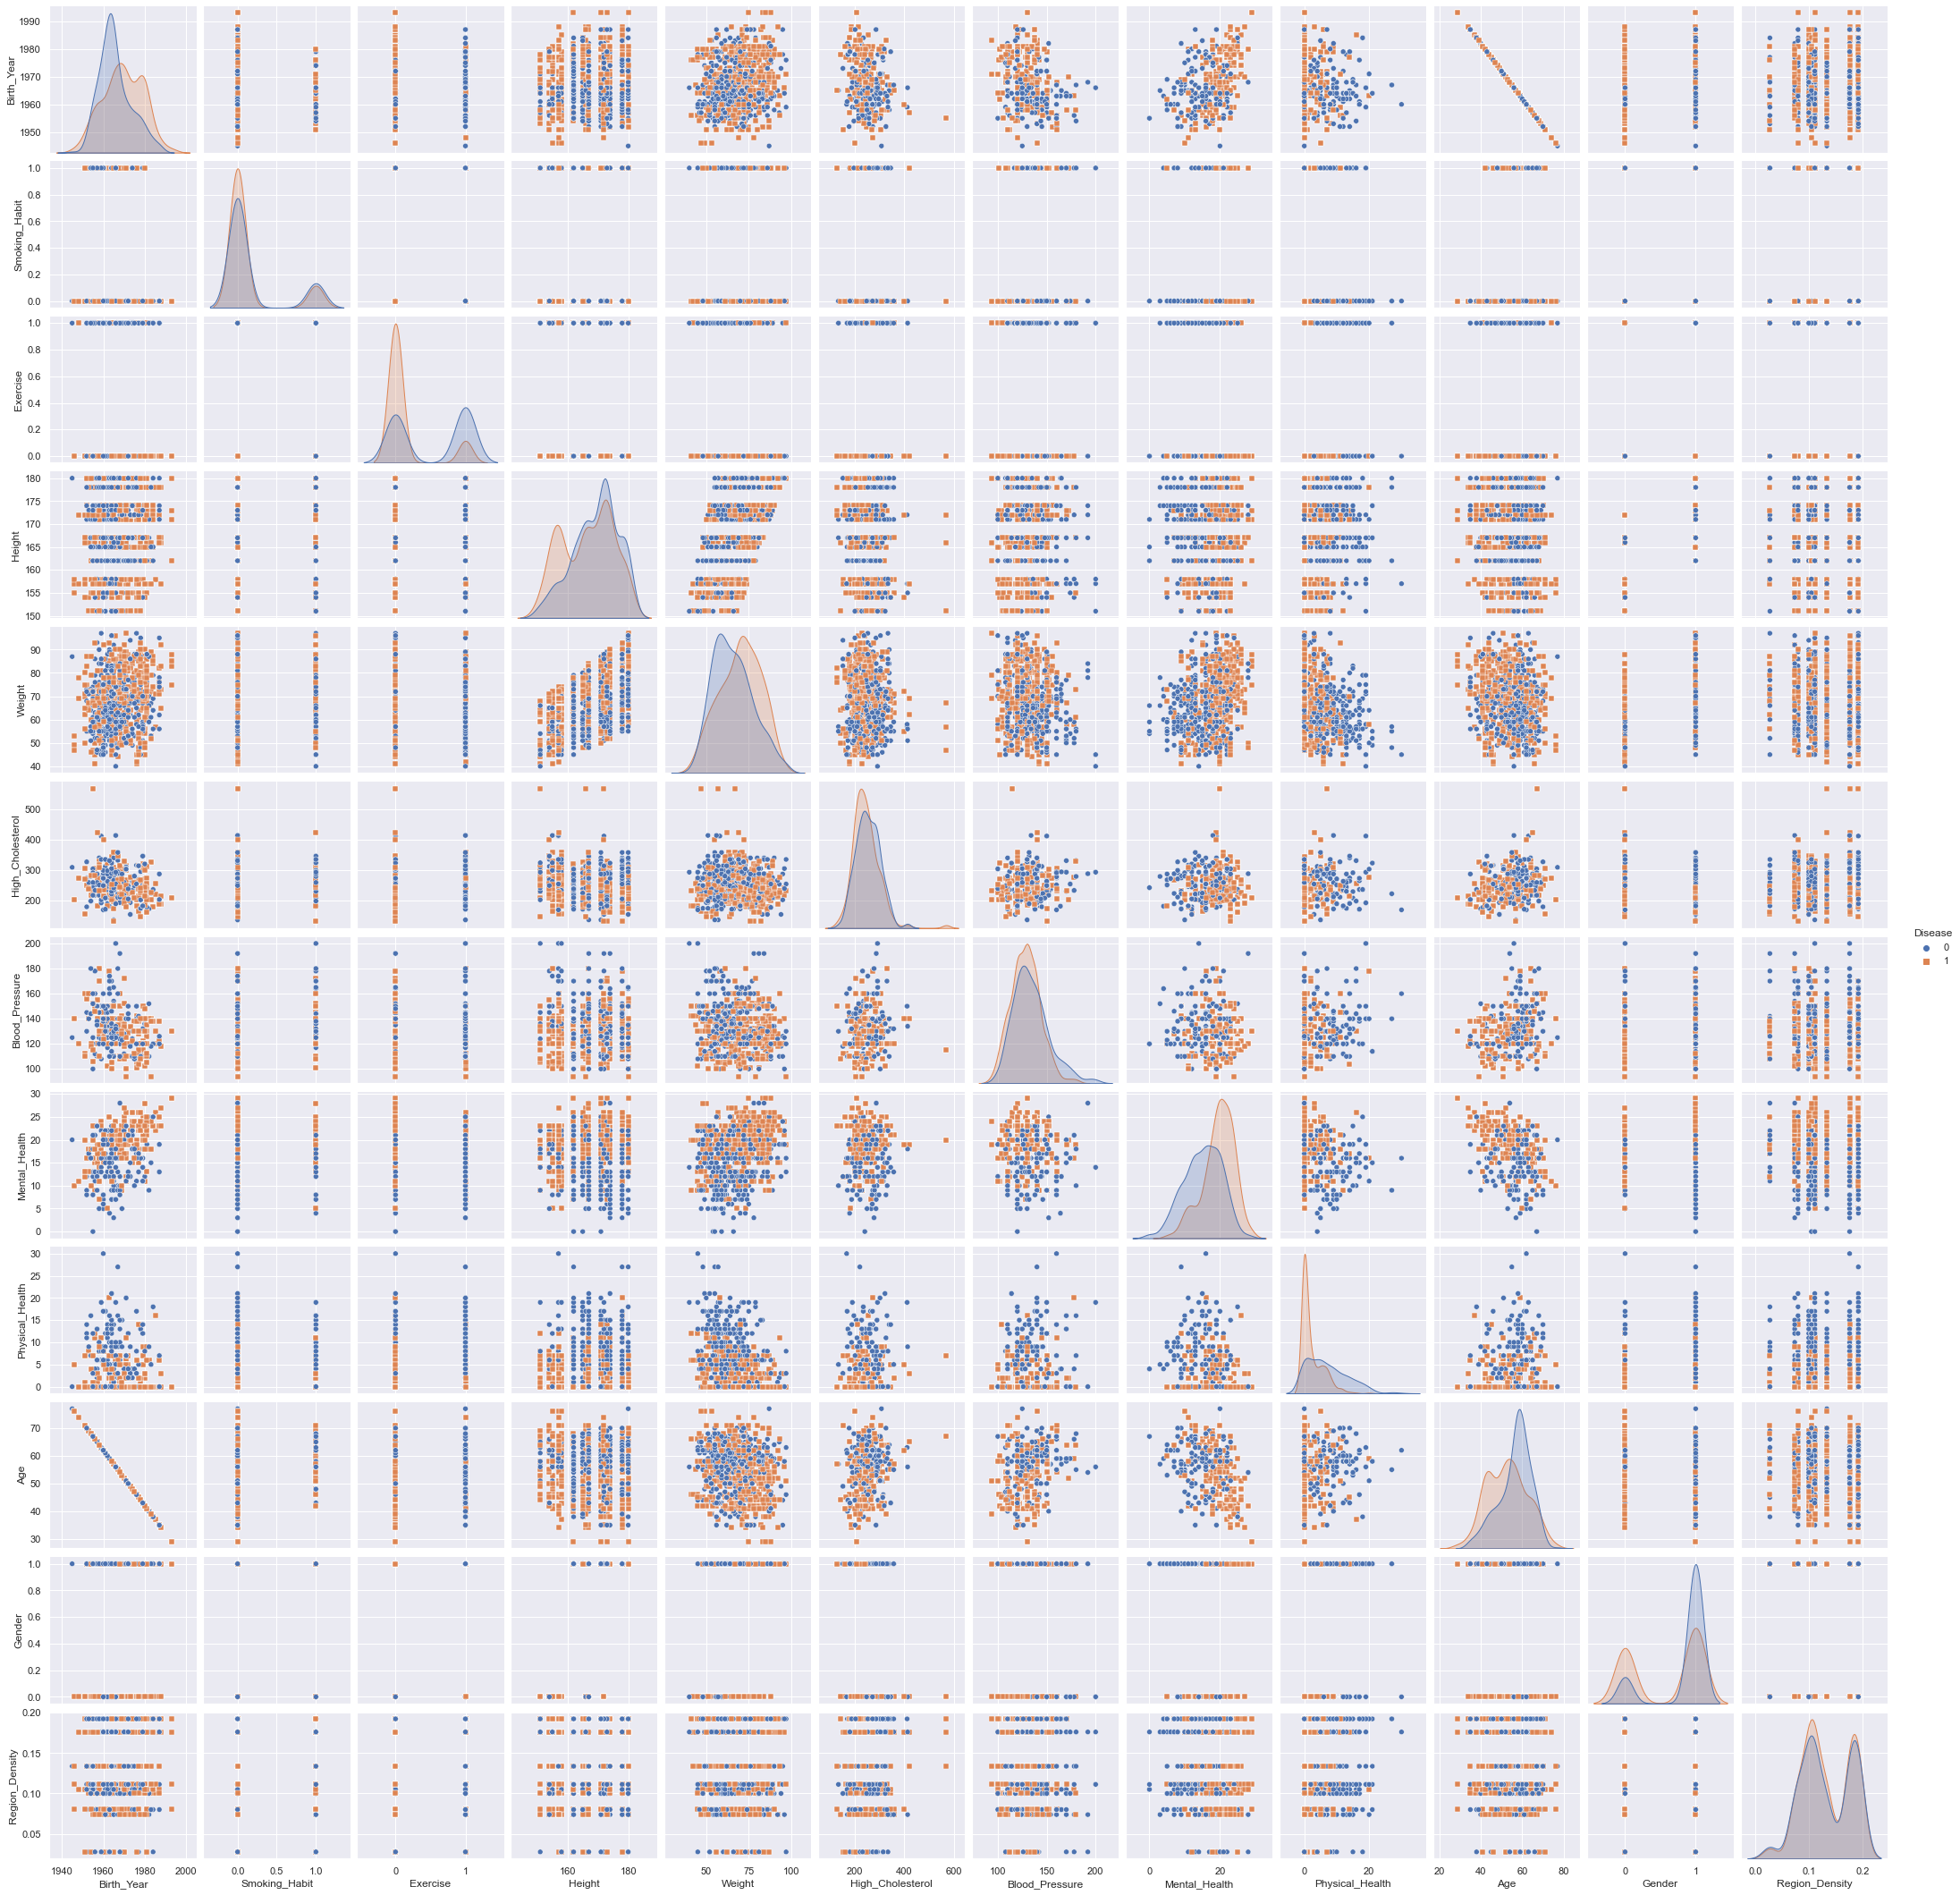

In [125]:
sns.set()

sns.pairplot(cleandf, hue = 'Disease', markers = ['o', 's'])

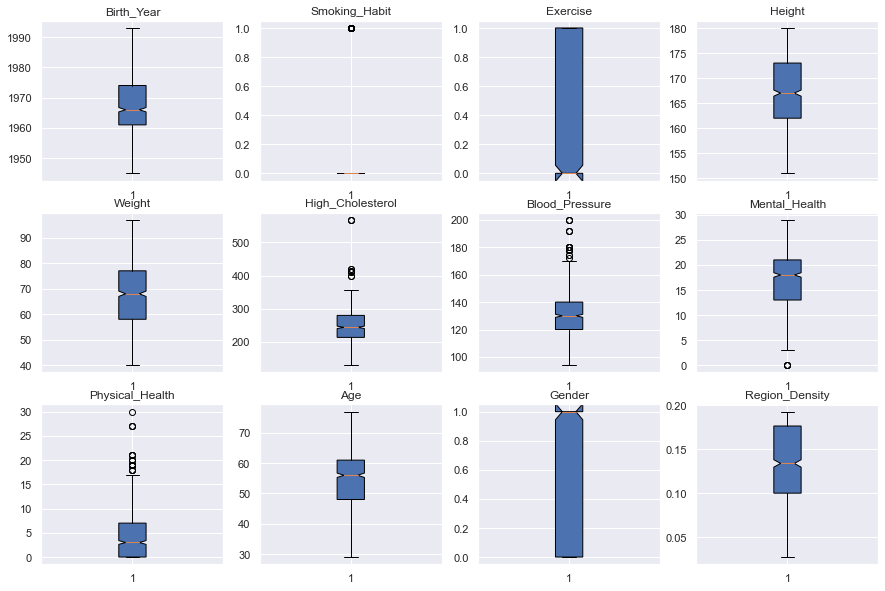

In [126]:
df_numeric_features = list(cleandf.select_dtypes(include = np.number).columns)
df_numeric_features.remove('Disease')

fig, ax = plt.subplots(math.ceil(len(df_numeric_features)/4),4, figsize = (15,10))
for ax, feat in zip(ax.flatten(), df_numeric_features):
    ax.boxplot(cleandf[feat], notch = True, patch_artist = True)
    ax.set_title(feat)

plt.show()

In [ ]:
def preprocessing(dataframe):
    # split x in numeric and categorical features
    xnumeric, xcategorical = dataframe.select_dtypes(include = np.number), dataframe.select_dtypes(exclude = np.number)

    # One-hot-encoding categorical features
    encoder = OneHotEncoder(handle_unknown='ignore')
    x_cat_encoded = pd.DataFrame(encoder.fit_transform(xcategorical).toarray(), columns = encoder.get_feature_names_out(), index = xcategorical.index) 

    # Scale numeric features
    scaler = RobustScaler()
    x_num_scaled = pd.DataFrame(scaler.fit_transform(xnumeric), index = xnumeric.index ,columns = xnumeric.columns)

    #PCA
    pca = PCA()
    pca_feat = pca.fit_transform(x_num_scaled)
    nr_of_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.8) + 1

    pca = PCA(n_components=nr_of_components)
    pca_feat = pca.fit_transform(x_num_scaled)
    pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
    pca_df = pd.DataFrame(pca_feat, index=x_num_scaled.index, columns=pca_feat_names)

    x_num_scaled_pca = pd.concat([x_num_scaled, pca_df], axis=1)

    xpreprocessed = pd.concat([x_num_scaled_pca, x_cat_encoded], axis = 1)

    return xpreprocessed

In [ ]:
#get rid of outliers with IQR method
    q1, q3, iqr = xnumeric.quantile(0.25), xnumeric.quantile(0.75), xnumeric.quantile(0.75) - xnumeric.quantile(0.25)
    cols = ['pdays', 'campaign', 'previous'] # The columns you want to search for outliers in

# Calculate quantiles and IQR
Q1 = dummy_df[cols].quantile(0.25) # Same as np.percentile but maps (0,1) and not (0,100)
Q3 = dummy_df[cols].quantile(0.75)
IQR = Q3 - Q1

In [109]:
x = preprocessing(x)
y = y.loc[x.index]

xtrain, xval, ytrain, yval = x.loc[xtrain_index], x.loc[xval_index], y.loc[xtrain_index], y.loc[xval_index]

model = LogisticRegression(max_iter = 500, random_state = 1)
model.fit(xtrain,ytrain)

ypred = model.predict(xval)

f1_score(yval, ypred)

UndefinedVariableError: name 'nb' is not defined

In [102]:
x

,Birth_Year,Smoking_Habit,Exercise,Height,Weight,High_Cholesterol,Blood_Pressure,Mental_Health,Physical_Health,Age,Gender,Region_Density
PatientID,,,,,,,,,,,,
1167,1965,NaN,NaN,155,67,358.0,120.0,21,2.0,57,NaN,NaN
1805,1969,NaN,NaN,173,88,230.0,142.0,9,NaN,53,NaN,NaN
1557,1974,NaN,NaN,162,68,226.0,122.0,26,NaN,48,NaN,NaN
1658,1958,NaN,NaN,180,66,313.0,125.0,13,8.0,64,NaN,NaN
1544,1968,NaN,NaN,180,58,277.0,125.0,18,2.0,54,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1909,1972,NaN,NaN,178,61,204.0,144.0,12,4.0,50,NaN,NaN
1386,1980,NaN,NaN,157,61,213.0,120.0,23,NaN,42,NaN,NaN
1088,1960,NaN,NaN,167,48,272.0,140.0,20,17.0,62,NaN,NaN


---
# Try better model

In [30]:
model = RandomForestClassifier(random_state = 2)
model.fit(xtrain,ytrain)

ypred = model.predict(xval)

print(f'F1 score with RandomForest: {f1_score(yval, ypred)}')

F1 score with RandomForest: 0.9590163934426229


---
# Try embedded feature selection

In [31]:
from sklearn.feature_selection import SelectFromModel

In [32]:
forest = RandomForestClassifier(random_state = 2)
forest.fit(xtrain, ytrain)
sfm = SelectFromModel(forest, prefit=True)

In [33]:
xtrain_fs = sfm.transform(xtrain)
xval_fs = sfm.transform(xval)

model = RandomForestClassifier(random_state = 2)
model.fit(xtrain_fs, ytrain)

ypred = model.predict(xval_fs)

print(f'F1 score with SelectFromModel: {f1_score(yval, ypred)}')

F1 score with SelectFromModel: 0.9590163934426229


# Try RFE

In [34]:
model = RandomForestClassifier(random_state = 2)
rfe = RFECV(model, cv = 5, scoring = 'f1')
rfe.fit(xtrain, ytrain)
opt_features = list(rfe.get_feature_names_out(input_features = list(xtrain.columns)))

In [35]:
xtrain_fs = rfe.transform(xtrain)
xval_fs = rfe.transform(xval)

model = RandomForestClassifier(random_state = 2)
model.fit(xtrain_fs, ytrain)

ypred = model.predict(xval_fs)

print(f'F1 score with RFE: {f1_score(yval, ypred)}')

F1 score with RFE: 0.97165991902834


---
# Hyperparameter tuning

In [36]:
param_grid = {
                'bootstrap': [True, False],
                'max_depth': [50, 60, 70, 80, 90, 100, None],
                'max_features': ['auto', 'sqrt'],
                'n_estimators': [200, 400, 600, 800, 1000]
            }

model = RandomForestClassifier(random_state = 2)
search = RandomizedSearchCV(estimator = model, param_distributions = param_grid, scoring = 'f1', cv = 3, random_state = 3, n_jobs = -1)
search.fit(xtrain_fs, ytrain)

print(str(search.best_params_).replace('{','').replace('}','').replace("'","").replace(':','='))

n_estimators= 1000, max_features= auto, max_depth= None, bootstrap= False


In [37]:
model = RandomForestClassifier(**search.best_params_, random_state = 2)
model.fit(xtrain_fs, ytrain)

ypred = model.predict(xval_fs)

print(f'F1 score with RandomizedSearch: {f1_score(yval, ypred)}')

F1 score with RandomizedSearch: 0.9795918367346939


# Try GridSearch instead of RandomizedSearch

In [38]:
from sklearn.model_selection import GridSearchCV

In [39]:
forest = RandomForestClassifier(random_state = 2)
search = GridSearchCV(forest, param_grid, n_jobs = -1)
search.fit(xtrain_fs, ytrain)

GridSearchCV(estimator=RandomForestClassifier(random_state=2), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [50, 60, 70, 80, 90, 100, None],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [200, 400, 600, 800, 1000]})

In [40]:
model = RandomForestClassifier(**search.best_params_, random_state = 2)
model.fit(xtrain_fs, ytrain)

ypred = model.predict(xval_fs)

print(f'F1 score with GridSearch: {f1_score(yval, ypred)}')

F1 score with GridSearch: 0.9795918367346939


In [41]:
from sklearn.metrics import confusion_matrix

confusion_matrix(yval, ypred)

array([[115,   2],
       [  3, 120]], dtype=int64)

In [42]:
print(classification_report(yval, ypred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       117
           1       0.98      0.98      0.98       123

    accuracy                           0.98       240
   macro avg       0.98      0.98      0.98       240
weighted avg       0.98      0.98      0.98       240

